In [27]:
import pickle
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from model import ResNetEncoder,Decoder
from dataset import Dataset
from build_vocab import Vocabulary
import torchvision.transforms as transforms

In [28]:
# Device configuration
use_bert=False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load vocabulary
with open('dataset/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
# load data
transforms_ = transforms.Compose([transforms.ToTensor(),
                transforms.Resize([512,512]), 
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ])

val_dataset=Dataset(df_path="dataset/df_val.pkl",vocab=vocab,transform=transforms_,max_cap_len=60)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,shuffle=False)
encoder = ResNetEncoder().to(device)
decoder = Decoder(vocab, use_bert=use_bert,device=device).to(device)
if use_bert:
    print('Load trained BERT Model')
    encoder_checkpoint = torch.load('./checkpoints/encoder_bert')
    decoder_checkpoint = torch.load('./checkpoints/decoder_bert')
else:
    print('Load trained Baseline Model')
    encoder_checkpoint = torch.load('./checkpoints/resnet_encoder_baseline')
    decoder_checkpoint = torch.load('./checkpoints/resnet_decoder_baseline')

encoder.load_state_dict(encoder_checkpoint['model_state_dict'])
decoder.load_state_dict(decoder_checkpoint['model_state_dict'])

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from '/opt/conda/lib/python3.8/site-packages/pandas/core/internals/blocks.py'>

In [43]:
%matplotlib inline

def print_sample(hypotheses,references,imgs, alphas, n,show_att):
    img_dim = 500 # 14*24
    for k in range(n):
        hyp_sentence = []
        for word_idx in hypotheses[k]:
            hyp_sentence.append(vocab.idx2word[word_idx])
        
        ref_sentence = []
        for word_idx in references[k]:
            ref_sentence.append(vocab.idx2word[word_idx])
            
        img1 = imgs[k][0]
        img2 = imgs[k][1] 
        if show_att:
            img1 = img1.resize([img_dim, img_dim], Image.LANCZOS)
            img2 = img2.resize([img_dim, img_dim], Image.LANCZOS)
            # for t in range(len(hyp_sentence)):
            #     plt.subplot(np.ceil(len(hyp_sentence) / 5.), 5, t + 1)

            #     plt.text(0, 1, '%s' % (hyp_sentence[t]), color='black', backgroundcolor='white', fontsize=12)
            #     plt.imshow(img1,cmap='gray')
            #     plt.imshow(img2,cmap='gray')
            #     current_alpha = alphas[0][t, :].detach().numpy()
            #     alpha = skimage.transform.resize(current_alpha, [img_dim, img_dim])
            #     if t == 0:
            #         plt.imshow(alpha, alpha=0,cmap='gray')
            #     else:
            #         plt.imshow(alpha, alpha=0.7,cmap='gray')
            #     plt.axis('off')
        else:
            f = plt.figure()
            f.add_subplot(1,2, 1)
            plt.imshow((img1*255).astype('uint8'))
            f.add_subplot(1,2, 2)
            plt.imshow((img2*255).astype('uint8'))
            plt.show(block=True)
            
        print('Hypotheses: '+" ".join(hyp_sentence))
        print('References: '+" ".join(ref_sentence))

Started getting result...


  1%|▏         | 11/807 [00:01<01:34,  8.40it/s]


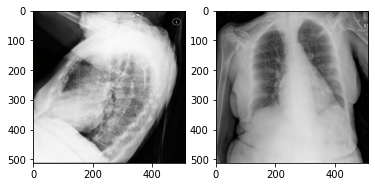

Hypotheses: no acute cardiopulmonary abnormalities . stable chronic lung disease .
References: no acute cardiopulmonary abnormalities . stable chronic lung disease .


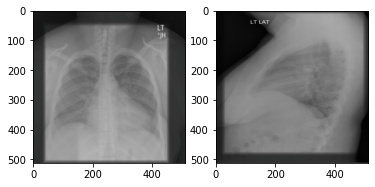

Hypotheses: cardiomegaly without no focal consolidation .
References: cardiomegaly but no focal consolidation .


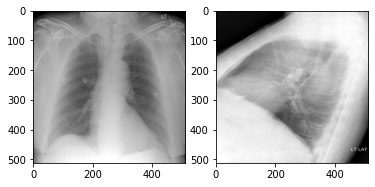

Hypotheses: comparison size normal . mildly tortuous aorta . no overt edema . no focal consolidation no pneumothorax . no significant pleural effusion though the extreme posterior right sulcus is excluded on the lateral image .
References: heart size normal . mildly tortuous aorta . no overt edema . no focal consolidation no pneumothorax . no significant pleural effusion though the extreme posterior right sulcus is excluded on the lateral image .


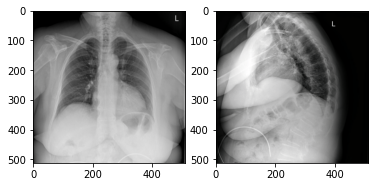

Hypotheses: no acute abnormality of the chest . right of and and and and and anterior fracture of distal clavicle clavicle . evaluated .
References: no acute abnormality of the chest . deformities of t and l unchanged abdomen abdomen fracture of right proximal humerus incompletely evaluated .


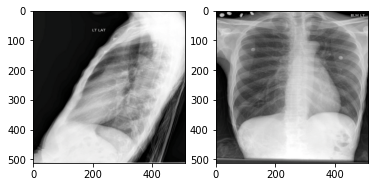

Hypotheses: no acute cardiopulmonary abnormality . emphysema with with to bronchovascular and possible hiatal carinatum . .
References: no acute cardiopulmonary abnormality . hyperlucent lungs related to cachexia and probable pectus excavatum deformity .


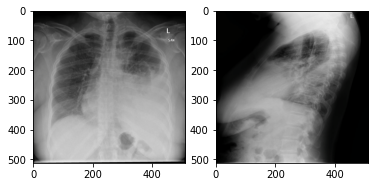

Hypotheses: right right upper lobe opacity which a small hiatal pleural effusion . left lung is clear .
References: large left lower lobe opacity represents a large layering pleural effusion . right lung is clear .


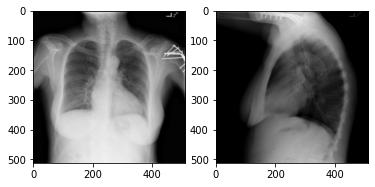

Hypotheses: no evidence of acute cardiopulmonary process .
References: no evidence of acute cardiopulmonary process .


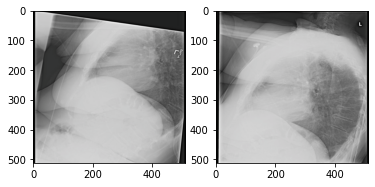

Hypotheses: emphysema without hiatal hernia as an acute abnormality identified .
References: cardiomegaly and hiatal hernia without an acute abnormality identified .


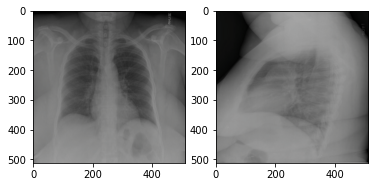

Hypotheses: no acute cardiopulmonary process .
References: no acute cardiopulmonary process .


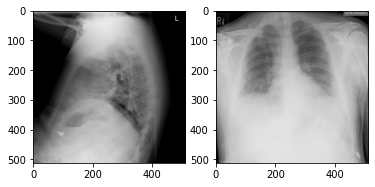

Hypotheses: low low lung volumes bronchovascular crowding and patchy opacities of atelectasis . no overt consolidation . no definite no effusion or pneumothorax . heart size within normal limits .
References: very low lung volumes bronchovascular crowding and bibasilar areas of atelectasis . no lobar consolidation . no appreciable pleural effusion or pneumothorax . heart size within normal limits .


In [44]:
references = [] 
test_references = []
hypotheses = [] 
all_imgs = []
all_alphas = []

PAD = 0
START = 1
END = 2
UNK = 3

print("Started getting result...")
decoder.eval()
encoder.eval()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Batches
for i, (img1,img2, cap,cap_len) in enumerate(tqdm(val_loader)):
    if i>10: 
        break
    img1_jpg= inv_normalize(img1.squeeze())
    img2_jpg= inv_normalize(img2.squeeze())
    imgs_jpg = [torch.permute(img1_jpg,(1,2,0)).numpy(),torch.permute(img2_jpg,(1,2,0)).numpy()]   
     
    # Forward prop.
    imgs = encoder(img1.to(device),img2.to(device))
    cap = cap.to(device)

    scores, caps_sorted, decode_lengths, alphas = decoder(imgs, cap,cap_len)
    targets = caps_sorted[:, 1:]

    # Remove timesteps that we didn't decode at, or are pads
    scores_packed = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
    targets_packed = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

    # References
    for j in range(targets.shape[0]):
        img_caps = targets[j].tolist() 
        clean_cap = [w for w in img_caps if w not in [PAD, START, END]]  # remove pad, start, and end
        img_captions = list(map(lambda c: clean_cap,img_caps))
        test_references.append(clean_cap)
        references.append(img_captions)

    # Hypotheses
    _, preds = torch.max(scores, dim=2)
    preds = preds.tolist()
    temp_preds = list()
    for j, p in enumerate(preds):
        pred = p[:decode_lengths[j]]
        pred = [w for w in pred if w not in [PAD, START, END]]
        temp_preds.append(pred)  # remove pads, start, and end
    preds = temp_preds
    hypotheses.extend(preds)

    all_alphas.append(alphas)
    all_imgs.append(imgs_jpg)

print_sample(hypotheses, test_references,all_imgs,all_alphas,n=10,show_att=False)